In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image

# Load data from the file
train_X = np.load('/content/drive/MyDrive/HW9/trainX.npy')
x_train = train_X/255.

In [ ]:
# Add noise
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)

In [ ]:
# Save original images and noised images
image_number = [1, 2, 3, 6, 7, 9]
for i in image_number:
  img = tf.keras.preprocessing.image.array_to_img(train_X[i, :, :, :])
  img_noise = tf.keras.preprocessing.image.array_to_img(x_train_noisy[i, :, :, :] * 255.)
  img = img.resize(size=(100, 100))
  img_noise = img_noise.resize(size=(100, 100))
  img.save('/content/drive/MyDrive/HW9/original_'+str(i), 'png')
  img_noise.save('/content/drive/MyDrive/HW9/noised_'+str(i), 'png')

In [ ]:
# build the model
# Auto-encoder
model_input = tf.keras.Input(shape=(32, 32, 3))
conv_1 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', strides=2)
conv_2 = tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same', strides=2)
flat_layer = tf.keras.layers.Flatten()
dense_layer = tf.keras.layers.Dense(128, activation='relu')

conv_1_output = conv_1(model_input)
conv_2_output = conv_2(conv_1_output)
flat_output = flat_layer(conv_2_output)
vector = dense_layer(flat_output)

# Decoder
decoder_dense_1 = tf.keras.layers.Dense(512, activation='relu')
decoder_reshape_layer = tf.keras.layers.Reshape(target_shape=(8, 8, 8))
decoder_deconv_2 = tf.keras.layers.Conv2DTranspose(8, 3, activation='relu', padding='same', strides=2)
decoder_deconv_1 = tf.keras.layers.Conv2DTranspose(16, 3, activation='relu', padding='same', strides=2)
decoder_final_sigmoid = tf.keras.layers.Conv2D(3, 3, activation='sigmoid', padding='same')

decoder_dense_1_output = decoder_dense_1(vector)
decoder_deconv_input = decoder_reshape_layer(decoder_dense_1_output)
deconv_2_output = decoder_deconv_2(decoder_deconv_input)
deconv_1_output = decoder_deconv_1(deconv_2_output)
decoder_output = decoder_final_sigmoid(deconv_1_output)

# Combine encoder and decoder
denoising_model = tf.keras.Model(inputs=model_input, outputs=decoder_output)


# Train the model
denoising_model.compile(optimizer='adam', loss='MSE')
denoising_model.fit(x_train_noisy, x_train, epochs=30, shuffle=True)

Epoch 1/30
266/266 [==============================] - 19s 69ms/step - loss: 0.0502
Epoch 2/30
266/266 [==============================] - 19s 72ms/step - loss: 0.0292
Epoch 3/30
266/266 [==============================] - 21s 79ms/step - loss: 0.0237
Epoch 4/30
266/266 [==============================] - 21s 78ms/step - loss: 0.0206
Epoch 5/30
266/266 [==============================] - 21s 78ms/step - loss: 0.0186
Epoch 6/30
266/266 [==============================] - 21s 78ms/step - loss: 0.0176
Epoch 7/30
266/266 [==============================] - 21s 80ms/step - loss: 0.0167
Epoch 8/30
266/266 [==============================] - 22s 81ms/step - loss: 0.0159
Epoch 9/30
266/266 [==============================] - 21s 80ms/step - loss: 0.0154
Epoch 10/30
266/266 [==============================] - 21s 79ms/step - loss: 0.0141
Epoch 11/30
266/266 [==============================] - 21s 78ms/step - loss: 0.0121
Epoch 12/30
266/266 [==============================] - 21s 78ms/step - loss: 0.0110
E

In [ ]:
# Save images from the decodes
decoder_results = denoising_model(x_train_noisy)
for i in image_number:
  img_decoder = tf.keras.preprocessing.image.array_to_img(decoder_results[i, :, :, :] * 255)
  img_decoder = img_decoder.resize(size=(100, 100))
  img_decoder.save('/content/drive/MyDrive/HW9/decoded_'+str(i), 'png')

In [ ]:
# Get vector results from the bottleneck layer
encoder_model = tf.keras.Model(inputs=model_input, outputs=vector)
vector_results = encoder_model(x_train_noisy)

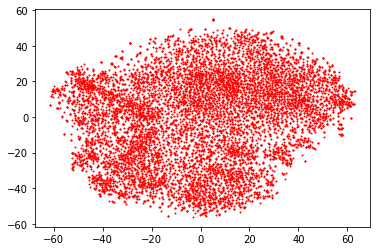

In [ ]:
# Use t-SNE to reduce reduce the vector dimension from 128 to 2
from sklearn.manifold import TSNE
vector_embedded = TSNE(n_components=2).fit_transform(vector_results)

# Plot the results
import matplotlib.pyplot as plt
plt.scatter(vector_embedded[:, 0], vector_embedded[:, 1], s=1, c='r')
plt.show()

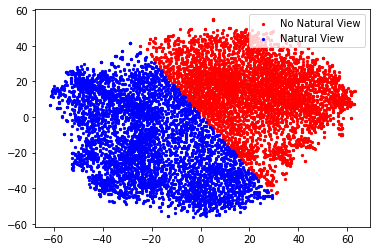

In [ ]:
# Use k-means to cluster 2-D vectors
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(vector_embedded)

f1 = plt.figure(1)
idx_1 = tf.where(kmeans.labels_ == 0)
idx_2 = tf.where(kmeans.labels_ == 1)
p1 = plt.scatter(vector_embedded[idx_1, 0], vector_embedded[idx_1, 1], color='r', s=5, marker = 'o', label='No Natural View')
p2 = plt.scatter(vector_embedded[idx_2, 0], vector_embedded[idx_2, 1], color='b', s=5, marker = 'o', label='Natural View')
plt.legend(loc = 'upper right')
f1.show()

In [35]:
# Calculate accuracy
val_X = np.load('/content/drive/MyDrive/HW9/valX.npy')
val_X = val_X/255.
val_Y = np.load('/content/drive/MyDrive/HW9/valY.npy')

n_val = 500
total_data = tf.concat([val_X, x_train], axis=0)
print(tf.shape(total_data))

tf.Tensor([9000   32   32    3], shape=(4,), dtype=int32)


In [36]:
total_results = encoder_model(total_data)
total_embedded = TSNE(n_components=2).fit_transform(total_results)
kmeans_val = KMeans(n_clusters=2, random_state=0).fit(total_embedded)
print(tf.shape(tf.where(val_Y != kmeans_val.labels_[:500])))
print(tf.shape(tf.where(val_Y == kmeans_val.labels_[:500])))

tf.Tensor([146   1], shape=(2,), dtype=int32)
tf.Tensor([354   1], shape=(2,), dtype=int32)


In [38]:
accuracy = tf.shape(tf.where(val_Y == kmeans_val.labels_[:500]))[0] / n_val
print(accuracy)

tf.Tensor(0.708, shape=(), dtype=float64)
